# Preprocessing 1: Loading, Stacking, Imputing 

Now we learn to pre-process the data for machine learning (ML). In the same way as OLS regression is sensitive to outliers and other quirks of the data, ML approaches can also be sensitive to distributions, gaps in the data and more. 

For the next few notebooks we will look at using more modern machine learning approaches to predict the 12 month average return of a company.

In this notebook we will preprocess the data to prepare it for machine learning. Let us familiarise ourselves with data again and formulate the problem.

We will now carry out the following steps:

1) Formulating the problem: Investing as a machine learning problem...

2) Stacking time-series: Removing the long term temporal structure...

3) Calculating average returns: Geometric calculation over the forecasting period

4) Using Index Data... benchmarking ... and providing a good way to normalise returns

5) Extracting the independent variables from the data

6) Imputing missing data



$%We want to create a machine learning model that can predict the 12 month average return of a company. At the moment, in the ```Data``` folder we have a number of different CSV files containing huge amounts of information on various companies. In this notebook, we will extract the relevant information from these files and preprocess the information ready for machine learning.$

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

Let us look at the files in the ```Data``` folder by using the ```os.listdir()```.

In [2]:
os.listdir("data")

['Beta_DnSide_24m.csv',
 'Diag DebtToEquity.csv',
 'Diag EPS.csv',
 'Diag EPSGrowth3yrAverage_Rothko.csv',
 'Diag FreeCashFlowpershare.csv',
 'Diag PE.csv',
 'Diag ROE.csv',
 'Diag SentimentNews.csv',
 'Diag TotalYield.csv',
 'EBITDA_SALES.csv',
 'EPS.csv',
 'GroupRank_Diag FreeCashFlowpers.csv',
 'GroupRank_NPL_Loans_egSector.csv',
 'Mkt_Beta_2yrs.csv',
 'NI_Sales.csv',
 'OperationalLev_USD.csv',
 'Rev_Quality.csv',
 'TotalReturn_BaseCCY.csv']

The file ```TotalReturn_BaseCCY.csv``` contains the monthly return data of around 6000 companies. Let us take a closer look at this file.

In [3]:
df = pd.read_csv('Data/TotalReturn_BaseCCY.csv') # load the return data into a pandas dataframe

nrows, ncols = df.shape
print("Number of rows in the dataframe: %i" % nrows)
print("Number of columns in the dataframe: %i" % ncols)
df.head()

Number of rows in the dataframe: 6376
Number of columns in the dataframe: 253


,NAME,TICKER,SECTOR,COUNTRY,2020-09-20,2020-08-31,2020-07-31,2020-06-30,2020-05-31,2020-04-30,...,2000-10-31,2000-09-30,2000-08-31,2000-07-31,2000-06-30,2000-05-31,2000-04-30,2000-03-31,2000-02-29,2000-01-31
0,Company No1,1,Financials,United Kingdom,NaN,NaN,NaN,NaN,NaN,NaN,...,0.045730,-0.120105,0.207501,-0.016259,0.201910,-0.061498,-0.226854,0.248221,0.435955,0.224755
1,Company No2,2,Financials,United Kingdom,NaN,NaN,NaN,NaN,NaN,NaN,...,0.038953,0.095348,0.104281,-0.062044,-0.100452,0.161520,-0.130285,0.221048,-0.072973,-0.241147
2,Chubb Plc,3,Industrials,United Kingdom,NaN,NaN,NaN,NaN,NaN,NaN,...,0.001878,-0.129013,0.024722,-0.062093,0.026172,0.031064,0.119904,0.222242,0.026770,-0.111193
3,Company No4,4,Consumer Discretionary,United Kingdom,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Company No5,5,Industrials,United Kingdom,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.000716,0.034200,0.223598,0.179246,-0.150297,0.251863,-0.096557,0.234714,-0.331340,-0.077761


The columns of the dataframe can be interpreted as follows:

- ***NAME*** - The name of the company
- ***TICKER*** - A unique key to identify each company.
- ***SECTOR*** - The sector that the company operates in.
- ***COUNTRY*** - The country that the company operates in.
- ***YYYY-MM-DD*** - This is best explained through an example. Aberdeen Asset Management PLC reported a return of 0.045730 in the month ending 2000-10-31. This means that from 2000-09-30 to 2000-10-31 the company reported a return of 0.045730.

The dataframe contains the return data of 6376 companies per month from 2000-01-31 to 2020-09-20. The other CSV files in the ```Data``` folder follow the same format. For example, ```Rev_Quality.csv``` gives us the monthly revenue quality of the same companies every month from 2000-01-31 to 2020-09-20.

## 1. Formulating the problem

We want to try and create a machine learning model that can predict the average 12 month return of any company across a 12 month period. 

The dependent variable for our models will be the average 12 month return of each company. We will use a 3 year sliding window ***without overlap***. This means that for the average return in 2004, we will use data from 2001, 2002, and 2003 as independent variables. For the average return in 2007 will use data from 2004, 2005, and 2006, as the dependent variables, and so on.

For the dependent variables let us take ROE as an example. For the average return in 2004, we will use the ROE for the last month of 2001, 2002, and 2003 as dependent variables. For the average return in 2007, we will use the ROE for the last month in 2004, 2005, and 2006, as dependent variables. We repeat this process for the remaining years and for the other files in the ```data``` folder. 

##  2. Stacking time-series data

As mentions, we are going to use the average return in 2004, 2007, 2010, 2013, 2016, 2019 as dependent variables so let us remove the years we are not going to use.

In [4]:
for col in df.columns[4:]:
    year = col[:4]
    if year not in ['2004', '2007', '2010', '2013', '2016', '2019']:
        df.drop(col, inplace=True, axis=1)

We want to include time-dependencies in our model but we also need to avoid having to deal with the noise and complexities of having to model long run time dependencies.

At the moment, the returns in ```df``` are stacked horizontally. Each row in each df represents a timeseries. To make things more simple we are going to remove the long run time dependencies (the time-series goes back many years). 
This is achieved by stacking the returns horizontally to make calculating the average returns much easier. The diagram below should make it easier to visualise what is going on.

<img src="Images/stacking_diagram.png" width="600">

Note that vertically stacking the data means that a company will appear in multiple rows of the dataframe for different years. We therefore add a column named ```YEAR``` that will indicate what year the return data has come from. Let us stack the data.

In [5]:
def stackData(x):
    # column names of new dataframe
    columns = [
    'NAME',
    'TICKER',
    'SECTOR',
    'COUNTRY',
    'DEC', 'NOV', 'OCT', 'SEP', 'AUG', 'JUL', 'JUN', 'MAY', 'APR', 'MAR', 'FEB', 'JAN',
    'YEAR']
    
    x_stacked = pd.DataFrame(columns=columns)
    
    subframes = []
    i = 4
    while i < x.shape[1]:
        # extract NAME, TICKER, SECTOR, COUNTRY, and 12 months of returns form x
        subframe = x[list(x.columns[0:4]) + list(x.columns[i:i+12])].copy()

        subframe['YEAR'] = int(x.columns[i][:4])
        subframe.columns = x_stacked.columns 

        # append the subframe to the end of x_stacked
        x_stacked = x_stacked.append(subframe)
        i += 12

    # drop any rows that have a missing value in it
    x_stacked = x_stacked.dropna(axis=0)

    # reset the index to go 0, 1, 2, 3, ...
    x_stacked.reset_index(drop=True, inplace=True)
    return x_stacked

In [6]:
X = stackData(df)
X.head()

,NAME,TICKER,SECTOR,COUNTRY,DEC,NOV,OCT,SEP,AUG,JUL,JUN,MAY,APR,MAR,FEB,JAN,YEAR
0,Company No8,8,Materials,United Kingdom,0.081739,0.000536,0.012925,0.060693,-0.082909,-0.027976,0.199121,-0.166487,-0.030634,0.010199,0.089024,0.147065,2019
1,Company No11,11,Industrials,United Kingdom,0.052051,0.000465,0.089029,0.008746,0.010037,-0.029802,0.220373,-0.150270,0.146007,-0.093946,0.050198,0.221012,2019
2,Barratt Developments PLC,16,Consumer Discretionary,United Kingdom,0.146727,0.055992,0.086991,0.036826,-0.025122,0.084072,0.036179,-0.103543,0.020446,-0.020010,0.124528,0.202027,2019
3,Company No17,17,Consumer Discretionary,United Kingdom,0.167707,0.087121,-0.008303,0.167081,-0.028497,0.025997,0.025968,-0.133021,0.022474,-0.013860,0.078142,0.165098,2019
4,Company No18,18,Industrials,United Kingdom,0.212478,-0.020787,0.076040,0.041902,0.040961,-0.181032,0.028458,-0.073428,-0.041146,-0.108438,0.062801,0.135193,2019


Let us see if there are any returns that are clearly outliers.  

In [7]:
months = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
maxmin = pd.DataFrame(columns=['max', 'min'], index=months)

maxmin = pd.DataFrame({
    "max"       : X[months].max(),                     # max value in each month
    "max_name"  : list(X.loc[X[months].idxmax()]['NAME']), # name of the company with the max value
    "max_year"  : list(X.loc[X[months].idxmax()]['YEAR']), 
    "min"       : list(X[months].min()),                     # min value in each month
    "min_name"  : list(X.loc[X[months].idxmin()]['NAME']), # name of the company with the min value
    "min_year"  : list(X.loc[X[months].idxmin()]['YEAR']),
})
maxmin

,max,max_name,max_year,min,min_name,min_year
JAN,7.256262,Company No5478,2004,-0.966667,Company No711,2019
FEB,389.906799,Company No3210,2004,-0.902840,Company No6210,2013
MAR,2.867885,Company No6076,2007,-0.990000,Company No711,2019
APR,99.000000,Company No711,2019,-0.953728,Company No2971,2007
MAY,9.000000,Company No711,2019,-0.915959,Company No5787,2019
JUN,3.447309,Company No6271,2004,-0.999000,Company No711,2019
JUL,6.150787,Company No3622,2013,-0.969207,Company No6366,2013
AUG,99.000000,Company No711,2019,-0.900000,Company No1791,2019
SEP,53.543182,Company No5701,2013,-0.880512,Company No711,2016
OCT,12.973864,Company No3690,2016,-0.900000,Company No711,2019


```Shinsei Bank Limited``` had a return of 390 for February 2004. This is an outlier. We can deal with this by clipping the data. Any returns that are above the 95th percentile are set to the 95th percentile, and any returns below the 5th percentile are set to the 5th percentile.

In order to avoid interjecting non-stationarities into the data we clip the returns in each each separately.

In [8]:
def boundStackedData(x):
    months = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
    years = list(set(x['YEAR']))
    
    for year in years:      
        x_year = x.loc[x['YEAR'] == year, months]
        upperlim = x_year[months].quantile(0.95)
        lowerlim = x_year[months].quantile(0.05)
        x_year.clip(lower=lowerlim, upper=upperlim, inplace=True, axis=1)
        x.loc[x['YEAR'] == year, months] = x_year
    return x

X = boundStackedData(X)

## 3. Calculating average returns

Now that we have clipped the returns we can look at calculating the average return across the 12 month periods. To calculate the average return, we will use the geometric mean which is normally formulated as follows
$$
    r = \prod_{i=1}^{12} r_i.
$$
Where $r_i$ is the is the return at the $i$-th month. This method is potentially very sensitive. For example if one of the returns is negative then $r$ will be negative. Clearly this is not what we want. We therefore use a slightly modified version of the formula
$$
    r = \prod_{i=1}^{12} (1 + r_i) - 1.
$$
From the table above, no company has a return less than -1 therefore  $(1 + r_i)$ will always be positive avoiding the issue of one negative return drastically affecting $r$. Let us find the geometric mean for our data.

In [9]:
def calculateGeometricMean(x):
    months = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
    x["AVERAGE RETURN"] = (x[months] + 1).product(axis=1) - 1

    # drop the monthly returns from the dataframe
    x = x.drop(months, axis=1)
    return x
    
X = calculateGeometricMean(X)
X.head()

,NAME,TICKER,SECTOR,COUNTRY,YEAR,AVERAGE RETURN
0,Company No8,8,Materials,United Kingdom,2019,0.250570
1,Company No11,11,Industrials,United Kingdom,2019,0.516823
2,Barratt Developments PLC,16,Consumer Discretionary,United Kingdom,2019,0.811012
3,Company No17,17,Consumer Discretionary,United Kingdom,2019,0.631597
4,Company No18,18,Industrials,United Kingdom,2019,0.152388


## 4. Using Index Data... benchmarking ... and providing a good way to normalise returns

Almost all strategies are benchmarked, be it against a style index or an absolute return (ie achieve a return of >0%). We will use a global equities index in this notebook to benchmark our tests, called the MSCI ALl Countries World Index (ACWI) which contains emerging and developed market stocks 

The data is presented as a monthly total return, weighting each stock in the index and calculating the price return and payment of dividends and stock to give a total return. This is then adjusted for common taxes imposed on large institutions such as withholding taxes. This is termed a "net return". 

In [10]:
index=pd.read_csv("index/INDEX.csv", skiprows=8)
index = index.drop(["NAME", "TICKER", "SECTOR", "COUNTRY"], axis=1) # drop the non-numeric columns
index.head()

,9/20/2020,8/31/2020,7/31/2020,6/30/2020,5/31/2020,4/30/2020,3/31/2020,2/29/2020,1/31/2020,12/31/2019,...,10/31/2001,9/30/2001,8/31/2001,7/31/2001,6/30/2001,5/31/2001,4/30/2001,3/31/2001,2/28/2001,1/31/2001
0,-0.0422,0.061207,0.052886,0.031953,0.04349,0.107128,-0.135004,-0.080771,-0.011044,0.035213,...,0.021103,-0.091604,-0.046299,-0.015965,-0.030922,-0.011752,0.07241,-0.067679,-0.08433,0.02514


More information about the global msci index can be found on [their website](https://www.msci.com/developed-markets). We use a similar concept to calculate returns over the test period we need using the file ... ```TotalReturn_BaseCCY.csv``` and using the following geometric return formula

$$
    r_i = \frac{1 + r_i}{1 + x_i} - 1.
$$

Where $r_i$ is the return in some month $i$, and $x_i$ is the global msci index in month $i$. Let us adjust the returns using the formula above.

In [11]:
from sklearn.preprocessing import MinMaxScaler

# load the return data into a dataframe
returns = pd.read_csv("Data/TotalReturn_BaseCCY.csv")

# the global msci data is missing values for the year 2000 so we remove those years
returns = returns[list(returns.columns[:-12])] 

# change the columns in the index data to be the same as the columns in the return data
index.columns = returns.columns[4:]

# calculate the geometric return
returns[returns.columns[4:]] += 1
returns[returns.columns[4:]] = returns[returns.columns[4:]].divide(1 + index.iloc[0], axis=1)
returns[returns.columns[4:]] -= 1

# Remove the years we are not interested in
for col in returns.columns[4:]:
    year = col[:4]
    if year not in ['2004', '2007', '2010', '2013', '2016', '2019']:
        returns.drop(col, inplace=True, axis=1)
        
returns.head()

,NAME,TICKER,SECTOR,COUNTRY,2019-12-31,2019-11-30,2019-10-31,2019-09-30,2019-08-31,2019-07-31,...,2004-10-31,2004-09-30,2004-08-31,2004-07-31,2004-06-30,2004-05-31,2004-04-30,2004-03-31,2004-02-29,2004-01-31
0,Company No1,1,Financials,United Kingdom,NaN,NaN,NaN,NaN,NaN,NaN,...,0.062257,0.106229,-0.003862,-0.021665,0.026977,-0.107461,-0.068498,0.017212,0.134124,-0.023603
1,Company No2,2,Financials,United Kingdom,NaN,NaN,NaN,NaN,NaN,NaN,...,0.115492,-0.077185,0.051913,0.144367,0.109332,0.017423,-0.017317,-0.031579,-0.162617,0.092197
2,Chubb Plc,3,Industrials,United Kingdom,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Company No4,4,Consumer Discretionary,United Kingdom,NaN,NaN,NaN,NaN,NaN,NaN,...,0.344558,0.041638,-0.027044,0.031550,0.018952,0.041955,0.096762,0.071833,-0.041366,-0.065798
4,Company No5,5,Industrials,United Kingdom,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.012368,-0.016117,0.147616,0.033039,-0.012902,-0.066767,-0.036570,0.095799,0.034421,0.049920


Now that we have adjusted the returns we need to preprocess the returns in the same way as we did in the previous notebook. To make this easier we simply copy a few functions from the previous notebook.

In [12]:
returns = stackData(returns)
returns = boundStackedData(returns)
returns = calculateGeometricMean(returns)

## 5. Extracting the independent variables from the data

At the moment X contains the average yearly return for each company in the years 2004, 2007, 2010, ... 2019. Using 2004 as an example, we use data from 2001, 2002, and 2003, as independent variables. Specificially, if we take ROE (return on equity), for the year 2004 we will use the ROE for 2003-12-31, 2002-12-31, and 2001-12-31 as dependent variables. We does this for every year and every CSV file in the ```Data``` folder.

In [13]:
def extractIndependentVariables(x, files):
    """
    For each file in files, extract the relevant independent variables. That is for some file f extract 
    the 12, 24, and 36 month prior for each year in x
    """
    x_ = x.copy()
    
    years = set(x_.YEAR) # the set of unique years in df1
    
    for file in files:
        print("Working on " + file + " ... ", end='')
        path = "Data/" + file # path to a CSV file in the data folder
        
        temp = pd.read_csv(path)
                
        # create the new column names that will go into x
        colname1 = file[:-4] + " 12 months prior"
        colname2 = file[:-4] + " 24 months prior"
        colname3 = file[:-4] + " 36 months prior"

        x_[[colname1, colname2, colname3]] = np.NaN       
                
        for y in years:

            # create the dates that we are interested in
            date1 = str(y - 1) + "-12-31" # 12 months prior
            date2 = str(y - 2) + "-12-31" # 24 months prior
            date3 = str(y - 3) + "-12-31" # 36 months prior

            # get every company with an average return in year y
            subx_ = x_[x_['YEAR'] == y]

            # get the companies in temp that have an average return in year y
            subtemp = temp[temp['TICKER'].isin(subx_['TICKER'])]

            # extract the columns we are interested in
            subtemp = subtemp[['TICKER', date1, date2, date3]]
            
            # rename the columns
            subtemp.columns = ['TICKER', colname1, colname2, colname3]
            
            # ensure that subtemp and subx_ have the same index
            indexes = pd.Series(index=subx_.TICKER, data=subx_.index, name='index')
            subtemp = subtemp.set_index('TICKER')
            subtemp = subtemp.merge(indexes, how='right', left_on='TICKER', right_index=True)
            subtemp = subtemp.set_index('index')
            
            # update x_ with the values in subtemp
            x_.update(subtemp)
            """
            x_ = pd.merge(x_, subtemp, 
                      how='left',
                      left_index=True,
                      right_index=True,
                      on=(colname1, colname2, colname3)
            )
            """
        print("DONE", end='\n')
        
    return x_

In [14]:
files = os.listdir('data')
files.remove('TotalReturn_BaseCCY.csv')

# we don't include the following features to avoid the data getting too large. Comment out this code to include all the data
[files.remove(file) for file in ['EBITDA_SALES.csv', 'OperationalLev_USD.csv', 'Rev_Quality.csv', 'NI_Sales.csv']]
X = extractIndependentVariables(X, files)
#X.head()

Working on Beta_DnSide_24m.csv ... DONE
Working on Diag DebtToEquity.csv ... DONE
Working on Diag EPS.csv ... DONE
Working on Diag EPSGrowth3yrAverage_Rothko.csv ... DONE
Working on Diag FreeCashFlowpershare.csv ... DONE
Working on Diag PE.csv ... DONE
Working on Diag ROE.csv ... DONE
Working on Diag SentimentNews.csv ... DONE
Working on Diag TotalYield.csv ... DONE
Working on EPS.csv ... DONE
Working on GroupRank_Diag FreeCashFlowpers.csv ... DONE
Working on GroupRank_NPL_Loans_egSector.csv ... DONE
Working on Mkt_Beta_2yrs.csv ... DONE


Most machine learning approaches struggle with outliers and so we clip the data, keeping in mind to clip data from the different years separately. This is also known as winsorising the data.
We kill off the extreme top and bottom 5th percentile of the datapoints per year.

In [15]:
columns = X.columns[6:]
years = list(set(X['YEAR']))
for year in years:
    X_year = X.loc[X['YEAR'] == year, columns]
    upperlim = X_year.quantile(0.95)  # 95th percentile
    lowerlim = X_year.quantile(0.05)  # 5th percentile
    
    X.loc[X['YEAR'] == year, columns] = X_year

As a final step, we normalise the data by scaling the dependent variables between 0 and 1. This avoids the learners we will apply needing to set coefficients to deal with high and low magnitude data items. For example Revenue can range from highe billions of US$ to low single digits. Return on Equity tends to be in a range 5-20%. By normalising we remove these magnitude differences and make life easier for our learners (..... but in the process lose the real values of the data).

We do not scale the average return so we retain positive and negative values. This will make it easier to see if our models predict a company to be making or losing money. 

In [16]:
from sklearn.preprocessing import MinMaxScaler

columns = X.columns[6:]
x = X[columns]
normalizer = MinMaxScaler((0, 1))
x = normalizer.fit_transform(x)
X[columns] = x

## 6. Imputing missing data
Some of the machine learning models that we are going to use cannot deal with missing data. In this section, we will see how we can use the k-nearest neighbours (KNN) to impute missing data. Suppose we have some dataset $\mathbf{X}$ such that

$$
\mathbf{X} = 
\begin{bmatrix}
\mathbf{x}_1 \\
\mathbf{x}_2 \\
\vdots \\
\mathbf{x}_n
\end{bmatrix} = 
\begin{bmatrix}
x_{11} & x_{12} & \dots & x_{1m} \\
x_{21} & x_{22} & \dots & x_{2m} \\
\vdots & \vdots &       & \vdots \\
x_{n1} & x_{n2} & \dots & x_{nm}
\end{bmatrix}
$$

Where each sample $\mathbf{x}_1, \mathbf{x}_2, \dots, \mathbf{x}_n$ has $m$ features. The steps of KNN are as follows:

1. Select $k$.
2. For each missing value $x_{ij}$ in $\mathbf{X}$ find the $k$ nearest neighbours to $\mathbf{x}_i$ in terms of euclidean distance that do not have a missing value in the $j$-th column. Let us call these samples $\hat{\mathbf{x}}_1, \hat{\mathbf{x}}_2, \dots, \hat{\mathbf{x}}_k$.
3. Replace $x_{ij}$ with the average of the $j$-th column for $\hat{\mathbf{x}}_1, \hat{\mathbf{x}}_2, \dots, \hat{\mathbf{x}}_k$. So
$$
    x_{ij} = \frac{1}{k} \sum_{l=1}^{k} \hat{x}_{lj}
$$

We need a way to pick a good value for $k$ to ensure our imputed values are as close to the real values as possible. We will do this by taking the following steps:

1. Remove any samples/rows that have a missing value in any column.
2. Artificially put missing values into this data.
3. Impute the artificial missing values using KNN for different values of $k$.
4. Compute the mean squared error between the true values and the missing values. 
5. Select the $k$ that produced the smallest mean squared error and use that to impute the real missing values. 

Let us look at how many missing values are in our data using the ```info()``` function.

In [17]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28014 entries, 0 to 28013
Data columns (total 45 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   NAME                                             28014 non-null  object 
 1   TICKER                                           28014 non-null  object 
 2   SECTOR                                           28014 non-null  object 
 3   COUNTRY                                          28014 non-null  object 
 4   YEAR                                             28014 non-null  object 
 5   AVERAGE RETURN                                   28014 non-null  float64
 6   Beta_DnSide_24m 12 months prior                  27628 non-null  float64
 7   Beta_DnSide_24m 24 months prior                  27032 non-null  float64
 8   Beta_DnSide_24m 36 months prior                  26424 non-null  float64
 9   Diag DebtToEquity 12 months 

from the table above, only some six of the columns have missing values. We want to put missing values into the data to reflect the real data as closely as possible. We could do this by limiting the artificial missing values to just the columns that contain missing data. 

### k-Nearest Neighbour Imputation.... which k??
KNN is the most popular form of imputation and it performs pretty well on most tasks. It is non-parametric and is referred to as an instance based approach as it computes a value basded on the value of other instances in the dataset. We are looking to imply what a missing feature value is for a subject instance, from the equivalent values for similar instances. Its powerful but comes with limitations...

#### Curse of dimensionality - a classic rookie error...
One key problem in using KNN is that K suffers from a classic problem; the curse of dimensionality. If you have 100 features in your dataset, you can determine if two instances are "similar" by comparing the distances between the two instances using anything between 1 to 100 features. The problem is that the curse of dimensionality states that in high dimensional spaces distances between nearest and farthest points from query points **become almost equal**

The rule of thumb is to use a maximum of 10 features to compare distances. But which features to use?? 

#### How to choose features to asses neighbours... hyperparameter tuning...
Below we conduct an excercise to select a random 10 features. We then try to select the best value of $K$. If K=1 we find the nearest single neighbour and assume the value of the feature we want to impute is the value of that instance'. K=10 would imply that we find the 10 instances that have to lowest Euclidean distance to out subject instance and take the median 10's target feature, using this to impute the subject's missing value.

#### Examine the data...
Let us count the number of null values in each column, divide through by the number of entries in each column to get a value $p$ and we can plot this information.

C:\Users\Alex\anaconda3\envs\main\lib\site-packages\ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':


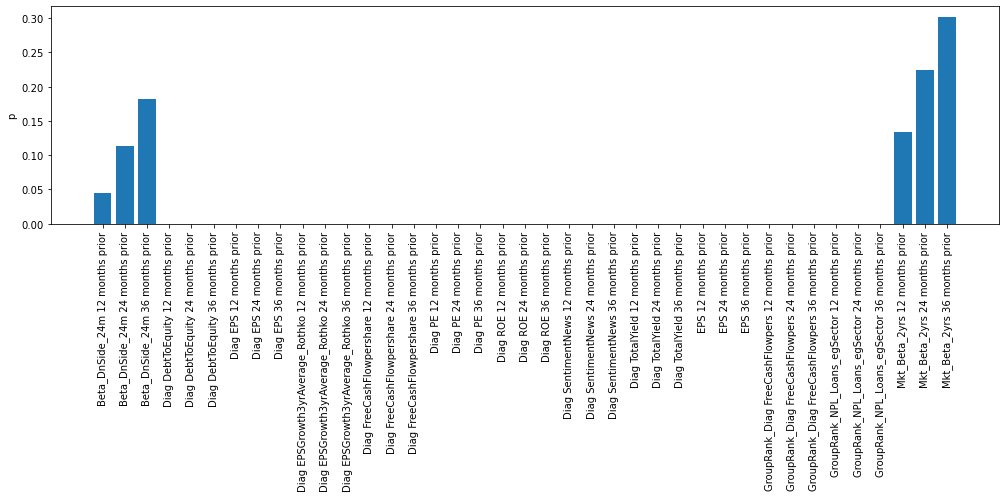

In [18]:
# Count the number of null values as % of total for each feature...
null_dist = X[X.columns[6:]].isnull().sum() # count the number of missing values in X
null_dist /= sum(null_dist) # convert the frequency distribution into a probability distribution

# turn null_dist from a series into a dataframe
null_dist = pd.DataFrame(null_dist)
null_dist.reset_index(inplace=True)
null_dist.columns = ['col_name', 'p']

fig, ax = plt.subplots(1,1, figsize=(17,4))
ax.bar(x=null_dist['col_name'], height=null_dist['p'])
ax.set_xticklabels(null_dist['col_name'], rotation = 90)
ax.set_ylabel("p");

#### Select a random 10 features tof our KNN.
Now that we have generated a probability distribution for the missing values, we can use numpy to start generating random columns according to our distribution.

In [19]:
choices = np.random.choice(
    null_dist.index, 
    p=null_dist['p'],
    size=10
)
for choice in choices:
    print(null_dist.loc[choice, 'col_name'])

Mkt_Beta_2yrs 36 months prior
Mkt_Beta_2yrs 36 months prior
Beta_DnSide_24m 24 months prior
Beta_DnSide_24m 24 months prior
Mkt_Beta_2yrs 36 months prior
Mkt_Beta_2yrs 12 months prior
Mkt_Beta_2yrs 24 months prior
Mkt_Beta_2yrs 12 months prior
Beta_DnSide_24m 24 months prior
Beta_DnSide_24m 36 months prior


Above we have printed 10 random column names according to the distribution that we calculated. Let us now prepare our test data by removing any samples that have a missing value in any of its columns.

In [20]:
X_test = X.dropna()    # drop any row that has any missing values
cols = X.columns[6:]   # dependent variable column names
X_test = X_test[cols]  # drop every column besides the dependent variables

We need a good number of missing values to put into ```X_test```. Let us look at the proportion of missing values in X to make our decision.

In [21]:
n_missing_values = X[X.columns[6:]].isnull().sum().sum() # total number of missing values in X
nrows, ncols = X[X.columns[6:]].shape
prop_missing_values = n_missing_values / (nrows * ncols) # proportion of missing values in X

print("There are %i missing values in X." % n_missing_values)
print("The proportion of missing values in X is %f." % prop_missing_values)

nrows, ncols = X_test.shape 
X_test_n_missing_values = round(nrows * ncols * prop_missing_values)

print("There should be %i artificial missing values put into X_test" % (X_test_n_missing_values))

There are 8702 missing values in X.
The proportion of missing values in X is 0.007965.
There should be 7816 artificial missing values put into X_test


#### Test different K values, and impose randomised nan on our dataset to test this...
We take fully populated data, insert randomised nulls (nan), impute using our value of K, and then check the loss... MSE.
Pick the best K.

So we should put 7816 missing values into ```X_test```. To speed things up a little, we will put half that number of missing values into ```X_test```.

In [22]:
from sklearn.impute import KNNImputer

In [23]:
"""
Find the best K value for the KNN... iterate...
We take fully populated data, insert randomised nulls (nan), impute using our value of K, and then check the loss... MSE.
Pick the best K.

Missing should only be put into columns with real missing values. Try to capture the distribution.
"""

n = round(7816 / 2)     # number of missing values we put into the data
m = 5                      # number of times we test each value of k
K = list(range(5, 61, 5))   # list of k values that we try in the KNN algorithm 
K.insert(0, 1)

nrows, ncols = X_test.shape
average_mse_list = []

best_k = -1
lowest_average_mse = np.inf

#Grid search over values of K...
for k in K:
    average_mse = 0
    
    # Now impose randomised nan values on our dataset, test 5 different 
    # randomisations in the hope that this generalises enough to give us a good imputation using KNN
    for _ in range(m):
        # create a copy of X_test that we randomly remove elements from
        X_test_temp = X_test.values.copy()

        # generate n random numbers in the range [0, nrows]
        rand_rows = np.random.randint(low = 0, high = nrows, size = n)

        # generate random columns according to the distribtion of missing values
        rand_cols = np.random.choice(null_dist.index, p=null_dist['p'], size=n)
        
        # replace randoms element in X_test with NaN
        X_test_temp[rand_rows, rand_cols] = np.nan 

        imputer = KNNImputer(n_neighbors=k)
        X_test_temp = imputer.fit_transform(X_test_temp)
        mse = ((X_test_temp - X_test) ** 2)
        mse = mse[mse != 0].mean().mean()
        average_mse += mse
        
    average_mse /= m
    average_mse_list.append(average_mse)
    
    if average_mse < lowest_average_mse:
        lowest_average_mse = average_mse
        best_k = k
        
    print("k = " + str(k) + " ... average MSE: " + str(average_mse))
print("The best k is %i which had an average MSE of %f." % (best_k, lowest_average_mse))

k = 1 ... average MSE: 0.001468630279764183
k = 5 ... average MSE: 0.0009780112774858316
k = 10 ... average MSE: 0.0008188768052445671
k = 15 ... average MSE: 0.0008502957829726508
k = 20 ... average MSE: 0.000824417549640946
k = 25 ... average MSE: 0.0008930056975837202
k = 30 ... average MSE: 0.0008220459795928552
k = 35 ... average MSE: 0.000898024127147189
k = 40 ... average MSE: 0.0008130134646992321
k = 45 ... average MSE: 0.000912643913402985
k = 50 ... average MSE: 0.0008738191536768976
k = 55 ... average MSE: 0.0008479257321604835
k = 60 ... average MSE: 0.0008392010535451787
The best k is 40 which had an average MSE of 0.000813.


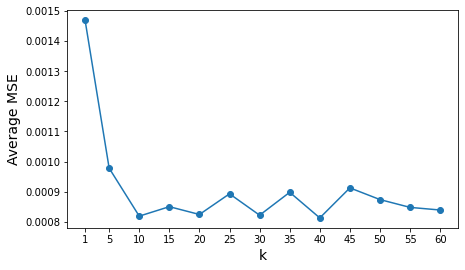

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(7,4))
ax.plot(K, average_mse_list, marker='o')
ax.set_xticks(K)
ax.set_xlabel("k", fontsize=14)
ax.set_ylabel("Average MSE", fontsize=14);

#### Hyperparameter tuning... pick the lowest MSE?
The k that got the lowest MSE was 25. This is our value of K. Let us use that to transform our original data.

In [28]:
imputer = KNNImputer(n_neighbors=25)
X[X.columns[6:]] = imputer.fit_transform(X[X.columns[6:]])

Finally, we save the transformed data.

In [29]:
X.to_csv('X.csv', index=False)